In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import datetime

data = pd.read_excel("./Online Retail.xlsx")

In [30]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [31]:
q_low = data["Quantity"].quantile(0.25)
q_hi  = data["Quantity"].quantile(0.75)
IQR=q_hi-q_low
data = data[(data["Quantity"]>(q_low-1.5*IQR)) & (data["Quantity"]<(q_hi+1.5*IQR))]

q_low = data["UnitPrice"].quantile(0.25)
q_hi  = data["UnitPrice"].quantile(0.75)
IQR=q_hi-q_low
data = data[(data["UnitPrice"]>(q_low-1.5*IQR)) & (data["UnitPrice"]<(q_hi+1.5*IQR))]

data[data["Quantity"] < 0] = np.nan
data[data["UnitPrice"] < 0] = np.nan
data = data.dropna()

In [32]:
data['Year']  = data['InvoiceDate'].dt.year
data['Month']  = data['InvoiceDate'].dt.month
data['Day']  = data['InvoiceDate'].dt.day

data = data.drop(["InvoiceDate"], axis=1) 

In [33]:
data

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850.0,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850.0,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850.0,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850.0,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850.0,United Kingdom,2010,12,1
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,0.85,12680.0,France,2011,12,9
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2.10,12680.0,France,2011,12,9
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,4.15,12680.0,France,2011,12,9
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,4.15,12680.0,France,2011,12,9


In [34]:
CustomerID, NumPurchase = np.unique(data['CustomerID'].values, return_counts=True)
CustomerID, NumPurchase = list(CustomerID), list(NumPurchase)
MoneySpent, RecentPurchase = [], []
for ids in tqdm(CustomerID):
    qualities = data['Quantity'].values[np.where(data['CustomerID'] == ids)]
    prices = data['UnitPrice'].values[np.where(data['CustomerID'] == ids)]
    val = 0
    for i in range(len(qualities)):
        val += qualities[i] * prices[i]
    MoneySpent.append(val)
    
    years = data['Year'].values[np.where(data['CustomerID'] == ids)]
    months = data['Month'].values[np.where(data['CustomerID'] == ids)]
    days = data['Day'].values[np.where(data['CustomerID'] == ids)]
    shopDates = []
    for j in range(len(years)):
        time = (datetime.date.today() - datetime.date(years[i],months[i],days[i])).days
        shopDates.append(time)
    mostRecentData = min(shopDates)
    RecentPurchase.append(mostRecentData)

100%|██████████| 4166/4166 [00:06<00:00, 608.32it/s]


In [39]:
newData = data.drop_duplicates(subset = ['CustomerID'], keep = 'first')

In [40]:
for index, row in tqdm(newData.iterrows()):
    pos = CustomerID.index(row["CustomerID"])
    newData.loc[index, 'NumPurchase'] = NumPurchase[pos]
    newData.loc[index, 'MoneySpent'] = MoneySpent[pos]
    newData.loc[index, 'RecentPurchase'] = RecentPurchase[pos]

4166it [00:01, 2588.45it/s]


In [41]:
newData

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day,NumPurchase,MoneySpent,RecentPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850.0,United Kingdom,2010,12,1,289.0,4783.46,4352.0
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6.0,2.10,13047.0,United Kingdom,2010,12,1,139.0,2607.16,4011.0
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12.0,3.75,12583.0,France,2010,12,1,149.0,3475.93,3982.0
86,536378,22386,JUMBO BAG PINK POLKADOT,10.0,1.95,14688.0,United Kingdom,2010,12,1,265.0,3121.97,3987.0
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23.0,4.25,15311.0,United Kingdom,2010,12,1,1888.0,14564.92,3980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536869,581222,22197,POPCORN HOLDER,12.0,0.85,14520.0,United Kingdom,2011,12,8,2.0,43.20,3981.0
536969,581233,22178,VICTORIAN GLASS HANGING T-LIGHT,6.0,1.95,13436.0,United Kingdom,2011,12,8,7.0,103.04,3981.0
537255,581241,22922,FRIDGE MAGNETS US DINER ASSORTED,12.0,0.85,15520.0,United Kingdom,2011,12,8,17.0,320.70,3981.0
538812,581416,22466,FAIRY TALE COTTAGE NIGHT LIGHT,1.0,1.95,14569.0,United Kingdom,2011,12,8,9.0,80.09,3981.0


In [68]:
newData = newData.drop(["InvoiceNo", "StockCode", "Description"], axis=1) 
newData = newData.drop(["Year", "Month", "Day", "Quantity", "UnitPrice", "Country"], axis=1) 

KeyError: "['InvoiceNo', 'StockCode', 'Description'] not found in axis"

In [44]:
# data['Recency'] = pd.qcut(RecentPurchase,q=5,labels=range(1,6))
# data['Frequency'] = pd.qcut(NumPurchase,q=5,labels=range(1,6))
# data['Monetary'] = pd.qcut(MoneySpent,q=5,labels=range(1,6))

In [45]:
newData

,CustomerID,Country,NumPurchase,MoneySpent,RecentPurchase
0,17850.0,United Kingdom,289.0,4783.46,4352.0
10,13047.0,United Kingdom,139.0,2607.16,4011.0
28,12583.0,France,149.0,3475.93,3982.0
86,14688.0,United Kingdom,265.0,3121.97,3987.0
106,15311.0,United Kingdom,1888.0,14564.92,3980.0
...,...,...,...,...,...
536869,14520.0,United Kingdom,2.0,43.20,3981.0
536969,13436.0,United Kingdom,7.0,103.04,3981.0
537255,15520.0,United Kingdom,17.0,320.70,3981.0
538812,14569.0,United Kingdom,9.0,80.09,3981.0


In [73]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
for i in ["NumPurchase", "MoneySpent", "RecentPurchase"]: #standard scaler.
        newData[i] = StandardScaler().fit_transform(newData[[i]].values)

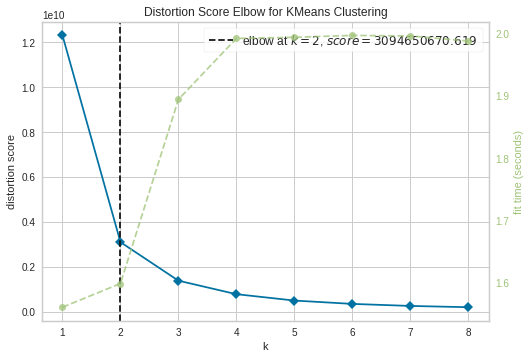

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
from yellowbrick.cluster import KElbowVisualizer
clusters = KMeans()
visualizer = KElbowVisualizer(clusters, k=(1,9))

visualizer.fit(newData)
visualizer.show()

In [75]:
clusters = KMeans(2)  # 3 clusters
clusters.fit(newData)

KMeans(n_clusters=2)

In [76]:
newData["Label"] = clusters.labels_
data["Label"] = clusters.labels_

/tmp/ipykernel_586/3539895227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Label"] = clusters.labels_


In [79]:
data_0 = data[data["Label"] == 0]
data_1 = data[data["Label"] == 1]

In [81]:
data_1.max()

/tmp/ipykernel_586/2165304818.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_1.max()


InvoiceNo                                   581578
Description       ZINC WILLIE WINKIE  CANDLE STICK
Quantity                                      21.0
UnitPrice                                     8.49
CustomerID                                 15298.0
Country                                Unspecified
Year                                          2011
Month                                           12
Day                                             31
NumPurchase                                 4592.0
MoneySpent                                75959.73
RecentPurchase                              4353.0
Label                                            1
dtype: object